# Image Classification

In this notebook I investigate how using machine learning models of different complexities can result in different outcomes when dealing sensitive data such as images of people's faces from different races and ethnicities. I do so by comparing how I very simple 3 layer convolutional neural network compares in accuracy to a more robuset VGG16-based model.

In [35]:
!pip3 install pydot

Importing the necessary libraries. For the most part, I use Tensorflow and Keras to build my computer vision model, cv2 for image preprocessing, and numpy and pandas for computation and data management and visualization.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.utils import plot_model
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

I set the necessary dimensions for which I want to resize and standardize all of my pixel data to.

In [2]:
img_height = 300
img_width = 300

We begin by fetching our data from the appropriate directory. The data we is taken from the FaceARG database, and in formatting the names of the files, the were named as such: age_gender_race.jpg. Hence, in order to create our dataset, I first go through our directory and read the file names using the `os.listdir()` method. Next, if the file name has a `.jpg` ending, I split the name and attribute the race of the individual to a list called `race_set`, and assign the pixel data of the individual to another list `face_img_pixels_set` at the corresponding index as the associated label. However, before I do this, I use `cv2.imread()` to convert the image to pixel data, and use the `cv2.resize()` method to resize all of our images to be 300 by 300.

In [3]:
age_set = []
gender_set = []
race_set = []
face_img_pixels_set = []
path = "./FaceRecognitionDataset"
dir_list = os.listdir(path)

for img_dir in dir_list:
    try:
        img_path = "./FaceRecognitionDataset"
        img_path += "/" + img_dir
        face_img_dir = os.listdir(img_path)
        for face_img in face_img_dir:
            if ".jpg" in face_img:
                face_img_split = face_img.split("_")
                age_set_str_int = face_img_split[0]
                age_set_str_int = int(age_set_str_int)
                age_set.append(age_set_str_int)
                gender_set_str_int = face_img_split[1]
                gender_set_str_int = int(gender_set_str_int)
                gender_set.append(gender_set_str_int)
                race_set_str_int = face_img_split[2]
                race_set_str_int = int(race_set_str_int)
                race_set.append(race_set_str_int)
                face_img_path = img_path + "/" + face_img
                face_img_pixels = cv2.imread(face_img_path)
                dim = (img_height, img_width)
                img_resize = cv2.resize(face_img_pixels, dim)
                cv2.imwrite(face_img_path, img_resize) 
                face_img_pixels_resized = cv2.imread(face_img_path)
                face_img_pixels_set.append(face_img_pixels_resized)     
    except:
        pass

In order to pass our `face_img_pixels_set` into our Tensorflow model, we need to use `np.stack()` to essentially flatten our array. Interestingly though, this is the first time I've encountered this issue, however, thank you to Michael Huang, I was able to learn that unless I flatten my data as so, I won't be able to convert it to tensors later on.

In [4]:
len(face_img_pixels_set)
face_img_pixels_set = np.stack(face_img_pixels_set)

In [5]:
print(face_img_pixels_set.shape)

(28663, 300, 300, 3)


In [6]:
race_set = np.array(race_set)

The first layer of my model is a data augmentation model, due to the fact that currently we have a relatively small training set (roughly 17k images). However, with a data augmentation layer, we can generate more data off of our existing training set, by randomly rotating and cropping the photos, as to our computer vision model, a change in even one pixel results in a completely different image.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2021-11-05 18:44:45.840595: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In order to train our model, we split our dataset into training, testing, and validation sets using the `train_test_split` method. We set our test size to 20%, train size to 60%, and validation size to 20%. The training set is used to build our model, the testing set is used to evaluate or model, and the validation set is used to evaluate our model while it is training, and appropriately fine tune it.

In [9]:
pixel_data_train, pixel_data_test, race_data_train, race_data_test = train_test_split(face_img_pixels_set, race_set, 
                                                                                        test_size = 0.2, random_state=123)
pixel_data_train, pixel_data_val, race_data_train, race_data_val = train_test_split(pixel_data_train, race_data_train,
                                                                                     test_size = 0.25,  random_state=123)

In my model, I also use a rescaling layer, such that the model can appropriately handle the data.

In [10]:
normalization_layer = layers.Rescaling(1./255)

The model that I choose to use for this classification model is heavily based on the VGG16 model. However, I opt to add more to the model's top layer, in an effort to enhance its classification abilities, by adding a sequence of 3 deep layers, with dropout layers in between, prior to beginning our sequence of convolutional layers. Outside of this though, our model follows essentially the same architecture as the classic VGG16 model, having 2 convolutional layers of depth 64, followed by pooling, 2 convolutional layers of depth 128, followed by pooling, 4 convolutional layers of depth 256, followed by pooling, 4 convolutional layers of depth 512, followed by pooling, 4 convolutional layers of depth 512, followed by pooling, and finally a layer to flatten our output and 3 dense layers. In between all of our convolutional layers, we also include batch normalization to normalize the layers' inputs by re-centering and re-scaling them.

In [60]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Dense(12, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(8, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid'),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
  layers.BatchNormalization(
        momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)
  ),
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(4096, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

We then compile our model. I do so with a learning rate of 0.001, such that our model is given sufficient time to learn the features of the dataset, use Sparse Categorical Cross Entropy as the loss function, a classic in classification tasks, and define our metric for training, which I choose as being accuracy, mse, mae, and mape.

In [61]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse', 'mae', 'mape'])

In [62]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
dense_17 (Dense)             (None, 300, 300, 12)      48        
_________________________________________________________________
dropout_11 (Dropout)         (None, 300, 300, 12)      0         
_________________________________________________________________
dense_18 (Dense)             (None, 300, 300, 8)       104       
_________________________________________________________________
dropout_12 (Dropout)         (None, 300, 300, 8)       0         
_________________________________________________________________
dense_19 (Dense)             (None, 300, 300, 1)      

In [49]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In training our model, we first need to convert our pixel data and race data to tensors, so that our Tensorflow model can actually process the data. We do this using the `tf.convert_to_tensor` method. In doing so, our data is then ready to be trained, I set the batch size to 256 due to how large the dataset we are using is, and train the model on only 5 epochs, mainly due to my limited computation power.

In [ ]:
epochs = 5
print(pixel_data_train[2].shape)
print(pixel_data_train.shape, pixel_data_train.dtype)
X = tf.convert_to_tensor(pixel_data_train)
print(X.shape)
Y = tf.convert_to_tensor(race_data_train, dtype=tf.float32)
history = model.fit(
  x = X, y = Y,
  validation_data = (pixel_data_val, race_data_val),
  epochs=epochs,
  batch_size = 256
)

(300, 300, 3)
(17197, 300, 300, 3) uint8
(17197, 300, 300, 3)
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


In [57]:
print(tf.__version__)

2.6.1


We are saving our model for future use:

In [58]:
model.save('baseline-cnn.h5')

As we can see from the graphs below, in the preliminary stages of training, our model followed a very traditional loss and accuracy curve, where it was descreasing and increasing respectively. However, this being said, the models still peformed suboptimally, peaking at a validation accuracy of roughly 60% after training for 5 epochs.

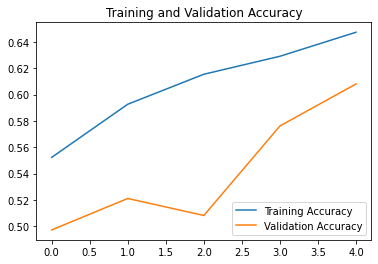

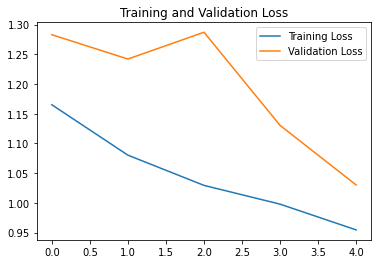

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Reflection on Model Outcome

To say I am surprised would be without a doubt an understatement. At the time it was introduced, VGG16 was a revolutionary new architecture that achieved never seen before results in the scope of image classification. In fact, in testing with large-scale image recognition, it received a 92.7% top-5 test accuracy in ImageNet when classifying for nearly 1000 classes. Thus, for any naive programmer who is wishing to create a model that can accurately classify based on race, facial expression, ethnicity, features, or any other similarly sensitive topics, choosing to create an architecture that emulates the general principles that VGG16 is based on is without a doubt a no brainer. However, as we have seen in the current study, this may not always be the best choice. This stems from the fact that when trained on the same exact datasets, and the same pre-processing steps, a model that was much less complex, had nearly 70 times fewer parameters, and that didn’t go to as great of a depth as the VGG16-based model, achieved a validation accuracy that was roughly 20% than that of the VGG16-based model. This opens up the door to several questions that can be asked. For example, this project, in specific, dealt with a very sensitive and prevalent topic, which is classifying people based on race. Such a practice can be used in police investigations to identify suspects or in cases as simple as opening your phone, but if well-known models such as VGG16 are not able to achieve a significant degree of accuracy in the task, it places doubt into the ethical practices of the model, as if individuals blindly use advanced and very uninterpretable models thinking that they can accurately take on similar classification tasks, they may place certain races and ethnicities at a disadvantage. Reflecting on how this outlook can be used to change my own approach in machine learning, in the future, I will definitely side more with testing my models more before saying I am confident with the model I present and always begin with more simple models before ramping up the complexity, as to minimize the amount of information that may be lost by adding unnecessary parameters

In [28]:
with open('pixelset.pkl', 'wb') as f:
    pickle.dump(face_img_pixels_set, f)

In [29]:
with open('raceset.pkl', 'wb') as f:
    pickle.dump(race_set, f)